In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
import plotly.graph_objs as go

In [3]:
moda_df = pd.read_parquet('moda2016-2023.parquet')
moda_df

,date,units,type,fabric,world,color,weekday,year,month,dayofweek,covid,quarter,dayofyear,dayofmonth
0,2016-01-23,1,PANTALON,TEJIDO PLANO,BEBÉ NIÑO,Verde,5,2016,1,5,False,1,23,23
3,2020-10-15,1,LEGGINGS,TEJIDO PUNTO,BEBÉ NIÑA,Verde,3,2020,10,3,True,4,289,15
4,2018-12-17,1,VESTIDO MANGA CORTA,TEJIDO PUNTO,NIÑA,Verde,0,2018,12,0,False,4,351,17
5,2018-12-19,1,VESTIDO MANGA CORTA,TEJIDO PUNTO,NIÑA,Verde,2,2018,12,2,False,4,353,19
6,2018-12-18,1,VESTIDO MANGA CORTA,TEJIDO PUNTO,NIÑA,Verde,1,2018,12,1,False,4,352,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12909000,2023-05-01,1,MINIFALDA,TEJIDO PLANO,NIÑA,Indigo,0,2023,5,0,False,2,121,1
12909001,2023-05-01,1,MINIFALDA,TEJIDO PLANO,NIÑA,Indigo,0,2023,5,0,False,2,121,1
12909002,2023-05-01,1,MINIFALDA,TEJIDO PLANO,NIÑA,Indigo,0,2023,5,0,False,2,121,1
12909003,2023-05-04,1,MINIFALDA,TEJIDO PLANO,NIÑA,Indigo,3,2023,5,3,False,2,124,4


In [4]:
def preprocessing(raw_df,world,type):
    df = raw_df[raw_df['world'] == world][raw_df['type']==type]
    df.drop(['world', 'type', 'color', 'fabric'], inplace=True, axis=1)
    df = df.groupby(['date','covid'])['units'].sum().to_frame().reset_index().sort_values('date')
    all_dates = pd.DataFrame({'date': pd.date_range(start='2016-01-01', end='2023-05-04')})
    df = pd.merge(all_dates, df, how='left', on='date')
    df['units'].fillna(0, inplace=True)
    df['units'] = df['units'].astype(int)
    df =pd.concat([df['date'].dt.isocalendar(), df], axis=1)
    df['year(ISO)'] = df['year']
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear']  = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['covid'].fillna(method='bfill', inplace=True)
    df['yearago'] = df['units'].shift(365)
    df['monthago'] = df['units'].shift(30)
    df['2weeksago'] = df['units'].shift(15)
    # df['Fecha'] = df['date']
    df['date'] = pd.to_numeric(df['date'])
    df['Fecha'] = pd.to_datetime(df['date'])
    df.fillna(0, inplace=True)
    df = df[['date','year', 'quarter','year(ISO)', 'week','month', 
             'day','dayofyear', 'dayofmonth',  'covid','yearago', 
             'monthago', '2weeksago','units']]
    return df

def preprocessing_month(raw_df,world,type):
    df = raw_df[raw_df['world'] == world][raw_df['type']==type]
    df.drop(['world', 'type', 'color', 'fabric'], inplace=True, axis=1)
    df['year_month'] = df['date'].dt.strftime('%Y-%m')
    df['year_month'] = pd.to_datetime(df['year_month'])
    df = df.groupby(['year_month','covid'])['units'].sum().to_frame().reset_index().sort_values('year_month')
    # all_dates = pd.DataFrame({'date': pd.date_range(start='2016-01-01', end='2023-05-04')})
    # df = pd.merge(all_dates, df, how='left', on='date')
    df['units'].fillna(0, inplace=True)
    df['units'] = df['units'].astype(int)
    df =pd.concat([df['year_month'].dt.isocalendar(), df], axis=1)
    df['year(ISO)'] = df['year']
    df['year'] = df['year_month'].dt.year
    df['quarter'] = df['year_month'].dt.quarter
    df['month'] = df['year_month'].dt.month
    # df['dayofyear']  = df['date'].dt.dayofyear
    # df['dayofmonth'] = df['date'].dt.day
    df['covid'].fillna(method='bfill', inplace=True)
    df['yearago'] = df['units'].shift(12)
    df['monthago'] = df['units'].shift(1)
    # df['2weeksago'] = df['units'].shift(15)
    # df['Fecha'] = df['date']
    df['year_month'] = pd.to_numeric(df['year_month'])
    # df['Fecha'] = pd.to_datetime(df['date'])
    df.fillna(0, inplace=True)
    df = df[['year_month','year', 'quarter','month', 
             'covid','yearago', 
             'monthago','units']]
    return df

def train_test_split(data, percent):
    data = data.values
    n = int(len(data)*(1-percent))
    train = data[:n]
    test = data[n:]
    X_train = train[:,:-1]
    y_train = train[:,-1]
    X_test = test[:,:-1]
    y_test = test[:,-1]
    
    return X_train, y_train, X_test, y_test

def go_plot(model, X_train, y_train, X_test, y_test):

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=pd.to_datetime(X_train[:,0]), y=model.predict(X_train), name='lineal')
    )
    fig.add_trace(
        go.Scatter(x=pd.to_datetime(X_test[:,0]), y=model.predict(X_test), name='pred')
    )
    fig.add_trace(
        go.Scatter(x=pd.to_datetime(X_test[:,0]), y=y_test, name='real')
    )
    fig.add_trace(
        go.Scatter(x=pd.to_datetime(X_train[:,0]), y=model.predict(X_train), name='full')
    )
    fig.update_layout(
        title='UNIDADES vs FECHA',
        xaxis_title='FECHA',
        yaxis_title='UNIDADES'
    )
    fig.show()

In [5]:
preprocessing_month(moda_df, 'NIÑO', 'PANTALON')

,year_month,year,quarter,month,covid,yearago,monthago,units
0,1451606400000000000,2016,1,1,False,0.0,0.0,97
1,1454284800000000000,2016,1,2,False,0.0,97.0,194
2,1456790400000000000,2016,1,3,False,0.0,194.0,228
3,1459468800000000000,2016,2,4,False,0.0,228.0,507
4,1462060800000000000,2016,2,5,False,0.0,507.0,1044
...,...,...,...,...,...,...,...,...
85,1672531200000000000,2023,1,1,False,75.0,1345.0,43
86,1675209600000000000,2023,1,2,False,102.0,43.0,28
87,1677628800000000000,2023,1,3,False,154.0,28.0,62
88,1680307200000000000,2023,2,4,False,200.0,62.0,119


In [6]:
def xgb_model(raw_df,world, type, percent, month=False):
    
    df = preprocessing_month(raw_df,world, type) if month else preprocessing(raw_df,world, type)
    X_train, y_train, X_test, y_test = train_test_split(df, percent)
    model = XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        # early_stopping_rounds=500,
                        # early_stopping_rounds=1000,
                        objective='reg:squarederror',
                        # objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )
    model.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = True)
    return (model, X_train, y_train, X_test, y_test)

In [7]:
model, X_train, y_train, X_test, y_test = xgb_model(moda_df[moda_df['year']>=2022],'NIÑO', 'PANTALON', 0.2, True)

[0]	validation_0-rmse:433.82115	validation_0-mae:253.39383	validation_0-mape:0.98578	validation_1-rmse:68.06657	validation_1-mae:53.28750	validation_1-mape:0.96382
[1]	validation_0-rmse:431.18654	validation_0-mae:251.53245	validation_0-mape:0.97650	validation_1-rmse:67.90117	validation_1-mae:53.07606	validation_1-mape:0.95309
[2]	validation_0-rmse:428.57206	validation_0-mae:249.68499	validation_0-mape:0.96730	validation_1-rmse:67.73685	validation_1-mae:52.86568	validation_1-mape:0.94240
[3]	validation_0-rmse:425.97757	validation_0-mae:247.85135	validation_0-mape:0.95817	validation_1-rmse:67.57360	validation_1-mae:52.65635	validation_1-mape:0.93178
[4]	validation_0-rmse:423.40293	validation_0-mae:246.03141	validation_0-mape:0.94912	validation_1-rmse:67.41143	validation_1-mae:52.44807	validation_1-mape:0.92120
[5]	validation_0-rmse:420.84800	validation_0-mae:244.22506	validation_0-mape:0.94014	validation_1-rmse:67.25031	validation_1-mae:52.24083	validation_1-mape:0.91068
[6]	validation_0

In [107]:
go_plot(*xgb_model(moda_df[moda_df['year']>=2018],'NIÑO', 'PANTALON', 0.2))

[0]	validation_0-rmse:33.08945	validation_0-mae:10.02301	validation_0-mape:inf	validation_1-rmse:25.63762	validation_1-mae:10.64629	validation_1-mape:inf
[1]	validation_0-rmse:32.84498	validation_0-mae:9.94187	validation_0-mape:inf	validation_1-rmse:25.37243	validation_1-mae:10.49795	validation_1-mape:inf
[2]	validation_0-rmse:32.60491	validation_0-mae:9.86145	validation_0-mape:inf	validation_1-rmse:25.11201	validation_1-mae:10.35106	validation_1-mape:inf
[3]	validation_0-rmse:32.36617	validation_0-mae:9.78243	validation_0-mape:inf	validation_1-rmse:24.85635	validation_1-mae:10.20881	validation_1-mape:inf
[4]	validation_0-rmse:32.13029	validation_0-mae:9.70464	validation_0-mape:inf	validation_1-rmse:24.60541	validation_1-mae:10.07069	validation_1-mape:inf
[5]	validation_0-rmse:31.89722	validation_0-mae:9.62918	validation_0-mape:inf	validation_1-rmse:24.35918	validation_1-mae:9.93902	validation_1-mape:inf
[6]	validation_0-rmse:31.66836	validation_0-mae:9.55438	validation_0-mape:inf	vali

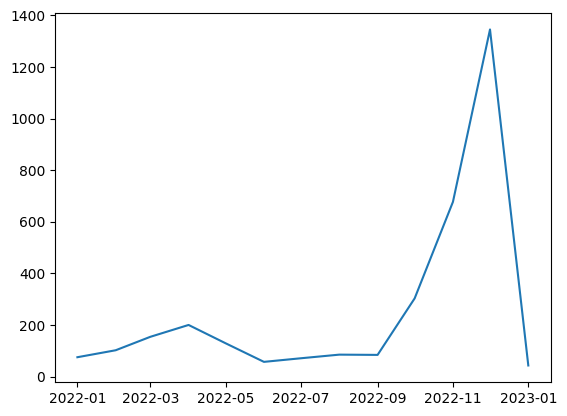

In [9]:
plt.plot(pd.to_datetime(X_train[:,0]), y_train)

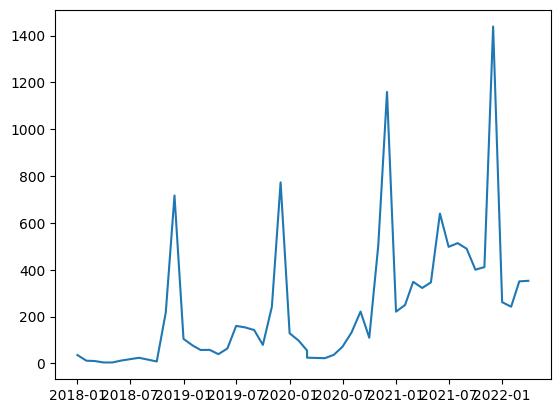

In [76]:
plt.plot(pd.to_datetime(X_train[:,0]), model.predict(X_train))

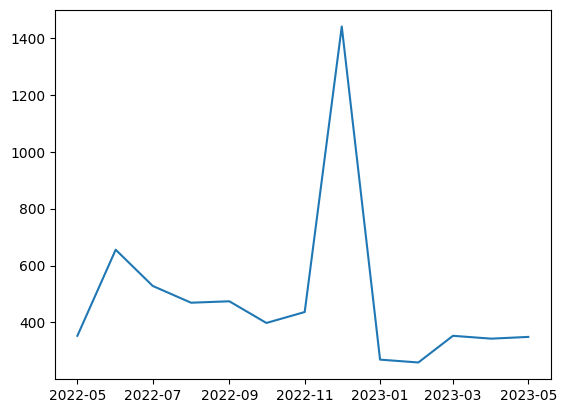

In [77]:
plt.plot(pd.to_datetime(X_test[:,0]), model.predict(X_test))

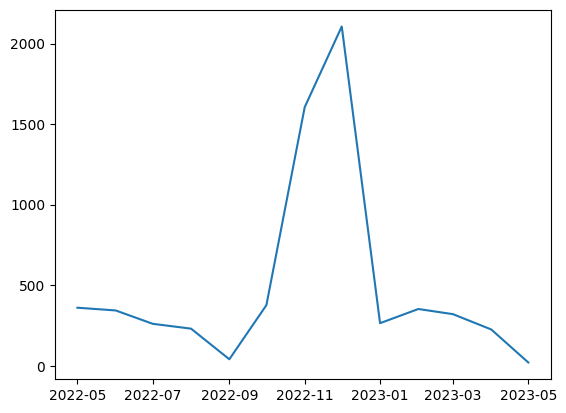

In [78]:
plt.plot(pd.to_datetime(X_test[:,0]), y_test)

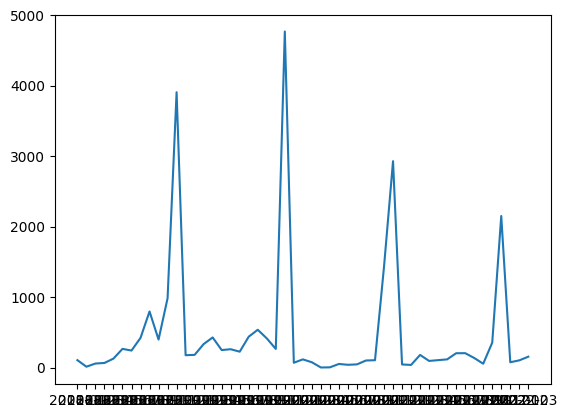

In [72]:
a_train = pd.DataFrame({'date': pd.to_datetime(X_train[:,0]), 'units' : y_train})
a_train['year_month'] = a_train['date'].dt.strftime('%Y-%m')
# plt.figure(figsize=(20, 10))
plt.plot(a_train.groupby('year_month')['units'].sum())

In [19]:
def df_month(raw_df,world,type):
    df = raw_df[raw_df['world'] == world][raw_df['type']==type]
    df.drop(['world', 'type', 'color', 'fabric'], inplace=True, axis=1)
    df['year_month'] = df['date'].dt.strftime('%Y-%m')
    df['year_month'] = pd.to_datetime(df['year_month'])
    df = df.groupby(['year_month','covid'])['units'].sum().to_frame().reset_index().sort_values('year_month')
    # all_dates = pd.DataFrame({'date': pd.date_range(start='2016-01-01', end='2023-05-04')})
    # df = pd.merge(all_dates, df, how='left', on='date')
    df['units'].fillna(0, inplace=True)
    df['units'] = df['units'].astype(int)
    df =pd.concat([df['year_month'].dt.isocalendar(), df], axis=1)
    df['year(ISO)'] = df['year']
    df['year'] = df['year_month'].dt.year
    df['quarter'] = df['year_month'].dt.quarter
    df['month'] = df['year_month'].dt.month
    # df['dayofyear']  = df['date'].dt.dayofyear
    # df['dayofmonth'] = df['date'].dt.day
    df['covid'].fillna(method='bfill', inplace=True)
    df['yearago'] = df['units'].shift(12)
    df['monthago'] = df['units'].shift(1)
    # df['2weeksago'] = df['units'].shift(15)
    # df['Fecha'] = df['date']
    # df['year_month'] = pd.to_numeric(df['year_month'])
    # df['year_month'] = df['date'].dt.to_period('M')
    # df['Fecha'] = pd.to_datetime(df['date'])
    df.fillna(0, inplace=True)
    df = df[['month','units']]
    


    # # Crear el boxplot de las ventas mensuales
    # plt.figure(figsize=(8, 6))
    # plt.boxplot(df['units'], by=df['year_month'].astype(str), showfliers=False)
    # plt.xlabel('year_month')
    # plt.ylabel('units')
    # plt.title('Boxplot de Ventas Mensuales')
    # plt.xticks(rotation=45)
    # plt.show()

    return df

In [53]:
# Agregar una columna 'year' con el año correspondiente a cada fila
df = df_month(moda_df,'NIÑO','PANTALON')
df['year'] = df.groupby('month').cumcount() + 1

# Pivoteo del DataFrame
pivoted_df = df.pivot(index='month', columns='year', values='units')

# Restablecer los nombres de las columnas
pivoted_df.columns = [f'{col}_year' for col in pivoted_df.columns]

# Restablecer el índice y convertir 'month' en una columna
pivoted_df = pivoted_df.reset_index()

# Mostrar el DataFrame pivoteado
pivoted_df

,month,1_year,2_year,3_year,4_year,5_year,6_year,7_year,8_year,9_year
0,1,97.0,1386.0,105.0,175.0,68.0,44.0,75.0,43.0,NaN
1,2,194.0,585.0,12.0,180.0,116.0,37.0,102.0,28.0,NaN
2,3,228.0,224.0,57.0,333.0,6.0,69.0,179.0,154.0,62.0
3,4,507.0,36.0,65.0,427.0,1.0,94.0,200.0,119.0,NaN
4,5,1044.0,337.0,127.0,248.0,3.0,105.0,129.0,7.0,NaN
5,6,1582.0,860.0,265.0,260.0,51.0,116.0,57.0,NaN,NaN
6,7,2014.0,605.0,241.0,225.0,39.0,203.0,71.0,NaN,NaN
7,8,2216.0,745.0,421.0,438.0,45.0,204.0,85.0,NaN,NaN
8,9,2198.0,661.0,796.0,536.0,100.0,136.0,84.0,NaN,NaN
9,10,2192.0,613.0,397.0,414.0,104.0,54.0,303.0,NaN,NaN


In [102]:
pd.set_option('display.max_rows', None)
df_month(moda_df,'NIÑO','PANTALON')

,month,units
0,1,97
1,2,194
2,3,228
3,4,507
4,5,1044
5,6,1582
6,7,2014
7,8,2216
8,9,2198
9,10,2192


In [95]:
grouped[0]

0            [97, 1386, 105, 175, 68, 44, 75, 43]
1           [194, 585, 12, 180, 116, 37, 102, 28]
2        [228, 224, 57, 333, 6, 69, 179, 154, 62]
3             [507, 36, 65, 427, 1, 94, 200, 119]
4           [1044, 337, 127, 248, 3, 105, 129, 7]
5              [1582, 860, 265, 260, 51, 116, 57]
6              [2014, 605, 241, 225, 39, 203, 71]
7              [2216, 745, 421, 438, 45, 204, 85]
8             [2198, 661, 796, 536, 100, 136, 84]
9             [2192, 613, 397, 414, 104, 54, 303]
10          [3773, 863, 983, 264, 1429, 353, 677]
11    [13786, 4798, 3906, 4768, 2928, 2150, 1345]
Name: 0, dtype: object

In [98]:
import plotly.graph_objects as go
import calendar

# Obtener las listas de valores del DataFrame 'grouped'
month_values = grouped[0].tolist()

# Obtener los nombres de los meses
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Crear la figura y agregar los boxplots
fig = go.Figure()
for i, values in enumerate(month_values):
    fig.add_trace(go.Box(y=values, name=month_names[i]))

# Establecer el título y los nombres de los ejes
fig.update_layout(title='Boxplot por Mes', xaxis_title='Mes', yaxis_title='Valor')

# Mostrar el gráfico
fig.show()

In [96]:
import plotly.graph_objects as go

# Obtener las listas de valores del DataFrame 'grouped'
grouped = df.groupby('month').apply(lambda x: x.iloc[:, 1:].values[:,0].flatten().tolist()).to_frame().reset_index()
month_values = grouped[0].tolist()

# Crear la figura y agregar los boxplots
fig = go.Figure()
for i, values in enumerate(month_values):
    fig.add_trace(go.Box(y=values, name=f'Mes {i+1}'))

# Establecer el título y los nombres de los ejes
fig.update_layout(title='Boxplot por Mes', xaxis_title='Mes', yaxis_title='Valor')

# Mostrar el gráfico
fig.show()




In [88]:
print(df.groupby('month').apply(lambda x: x.iloc[:, 1:].values[:,0].flatten().tolist()).to_frame())

                                                 0
month                                             
1             [97, 1386, 105, 175, 68, 44, 75, 43]
2            [194, 585, 12, 180, 116, 37, 102, 28]
3         [228, 224, 57, 333, 6, 69, 179, 154, 62]
4              [507, 36, 65, 427, 1, 94, 200, 119]
5            [1044, 337, 127, 248, 3, 105, 129, 7]
6               [1582, 860, 265, 260, 51, 116, 57]
7               [2014, 605, 241, 225, 39, 203, 71]
8               [2216, 745, 421, 438, 45, 204, 85]
9              [2198, 661, 796, 536, 100, 136, 84]
10             [2192, 613, 397, 414, 104, 54, 303]
11           [3773, 863, 983, 264, 1429, 353, 677]
12     [13786, 4798, 3906, 4768, 2928, 2150, 1345]


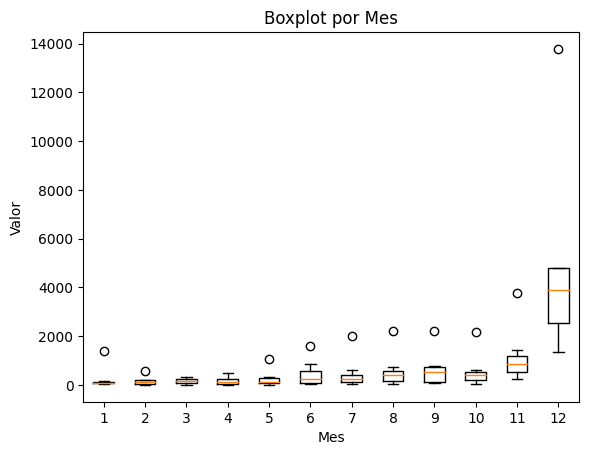

In [84]:
grouped = df.groupby('month').apply(lambda x: x.iloc[:, 1:].values[:,0].flatten().tolist())

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Crear el boxplot
ax.boxplot(grouped.values)

# Establecer las etiquetas del eje x
ax.set_xticklabels(grouped.index)

# Establecer el título y los nombres de los ejes
ax.set_title('Boxplot por Mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor')

# Mostrar el gráfico
plt.show()


In [20]:
df_month(moda_df,'NIÑO','PANTALON').groupby('month')['units'].mean().to_frame().round().reset_index()

,month,units
0,1,249.0
1,2,157.0
2,3,146.0
3,4,181.0
4,5,250.0
5,6,456.0
6,7,485.0
7,8,593.0
8,9,644.0
9,10,582.0


In [26]:
quartiles = [0.25, 0.50, 0.75]
quantiles = df_month(moda_df[moda_df['year']>=2018], 'NIÑO', 'PANTALON').groupby('month')['units'].quantile(quartiles)
quantiles = quantiles.unstack().add_prefix('quantile_')
means_df = df_month(moda_df[moda_df['year']>=2018], 'NIÑO', 'PANTALON').groupby('month')['units'].agg(['mean', 'std', 'min', 'max', 'median', 'count']).reset_index()

quantiles

,quantile_0.25,quantile_0.5,quantile_0.75
month,,,
1,50.00,71.5,97.50
2,30.25,69.5,112.50
3,59.50,69.0,166.50
4,72.25,106.5,179.75
5,31.50,116.0,128.50
6,57.00,116.0,260.00
7,71.00,203.0,225.00
8,85.00,204.0,421.00
9,100.00,136.0,536.00


In [23]:
means_df

,month,mean,std,min,max,median,count
0,1,85.000000,49.666890,43,175,71.5,6
1,2,79.166667,64.734586,12,180,69.5,6
2,3,122.857143,110.211053,6,333,69.0,7
3,4,151.000000,150.163910,1,427,106.5,6
4,5,103.166667,91.100860,3,248,116.0,6
5,6,149.800000,105.984433,51,265,116.0,5
6,7,155.800000,93.686712,39,241,203.0,5
7,8,238.600000,183.916557,45,438,204.0,5
8,9,330.400000,320.407241,84,796,136.0,5
9,10,254.400000,166.545189,54,414,303.0,5


,date,year,quarter,year(ISO),week,month,day,dayofyear,dayofmonth,covid,yearago,monthago,2weeksago,units
0,1451606400000000000,2016,1,2015,53,1,5,1,1,False,0.0,0.0,0.0,0
1,1451692800000000000,2016,1,2015,53,1,6,2,2,False,0.0,0.0,0.0,0
2,1451779200000000000,2016,1,2015,53,1,7,3,3,False,0.0,0.0,0.0,0
3,1451865600000000000,2016,1,2016,1,1,1,4,4,False,0.0,0.0,0.0,0
4,1451952000000000000,2016,1,2016,1,1,2,5,5,False,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,1682812800000000000,2023,2,2023,17,4,7,120,30,False,8.0,6.0,10.0,8
2677,1682899200000000000,2023,2,2023,18,5,1,121,1,False,13.0,10.0,3.0,3
2678,1682985600000000000,2023,2,2023,18,5,2,122,2,False,4.0,6.0,0.0,0
2679,1683072000000000000,2023,2,2023,18,5,3,123,3,False,6.0,3.0,0.0,3


In [48]:
monthly_pred

,month,units
0,1,105
1,2,12
2,3,57
3,4,65
4,5,127
...,...,...
61,1,43
62,2,28
63,3,62
64,4,119


In [103]:
# means = df_month(moda_df[moda_df['year']>=2018],'NIÑO','PANTALON').groupby('month')['units'].mean().to_frame().round().reset_index()
monthly_pred = df_month(moda_df[moda_df['year']>=2018],'NIÑO','PANTALON')
means_df = monthly_pred.groupby('month')['units'].agg(['mean', 'std', 'min', 'max', 'median', 'count']).reset_index()
means_df
quartiles = [0.25, 0.50, 0.75]
quantiles = monthly_pred.groupby('month')['units'].quantile(quartiles)
quantiles = quantiles.unstack().add_prefix('quantile_')
means_df = pd.merge(means_df, quantiles, on='month', how='left')
means_df

,month,mean,std,min,max,median,count,quantile_0.25,quantile_0.5,quantile_0.75
0,1,85.000000,49.666890,43,175,71.5,6,50.00,71.5,97.50
1,2,79.166667,64.734586,12,180,69.5,6,30.25,69.5,112.50
2,3,122.857143,110.211053,6,333,69.0,7,59.50,69.0,166.50
3,4,151.000000,150.163910,1,427,106.5,6,72.25,106.5,179.75
4,5,103.166667,91.100860,3,248,116.0,6,31.50,116.0,128.50
5,6,149.800000,105.984433,51,265,116.0,5,57.00,116.0,260.00
6,7,155.800000,93.686712,39,241,203.0,5,71.00,203.0,225.00
7,8,238.600000,183.916557,45,438,204.0,5,85.00,204.0,421.00
8,9,330.400000,320.407241,84,796,136.0,5,100.00,136.0,536.00
9,10,254.400000,166.545189,54,414,303.0,5,104.00,303.0,397.00


In [ ]:
model.predict

In [ ]:
plt.plot(pd.to_datetime(X_test[:,0]), model.predict(X_test))

In [114]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_log_error as MSLE

In [115]:
MSLE(y_test, model.predict(X_test))

0.7785495169244179

In [116]:
MAPE(y_test, model.predict(X_test))

1.5879473645915954

In [152]:
y_train.shape

(13,)

In [118]:
MSE(y_test, model.predict(X_test))

49194.701085875924

In [143]:
np.concatenate((X_train[:,0],X_test[:,0]))

array([1640995200000000000, 1643673600000000000, 1646092800000000000,
       1648771200000000000, 1651363200000000000, 1654041600000000000,
       1656633600000000000, 1659312000000000000, 1661990400000000000,
       1664582400000000000, 1667260800000000000, 1669852800000000000,
       1672531200000000000, 1675209600000000000, 1677628800000000000,
       1680307200000000000, 1682899200000000000], dtype=object)

In [32]:
dates = np.concatenate((X_train[:,0],X_test[:,0]))

In [33]:
preds = np.concatenate((model.predict(X_train),model.predict(X_test)))

In [37]:
preds_df = pd.DataFrame({'month': dates, 'pred': preds})
preds_df['month'] = pd.to_datetime(preds_df['month']).dt.strftime('%m').astype(int)
preds_df

,month,pred
0,1,78.883583
1,2,102.294098
2,3,152.826477
3,4,192.697525
4,5,131.624695
5,6,62.845161
6,7,71.167320
7,8,78.757523
8,9,87.049065
9,10,301.848419


In [213]:
preds_df['month'] = pd.to_datetime(preds_df['month']).dt.month
month_group_df = preds_df.groupby('month')['pred'].agg(['mean', 'std', 'min', 'max', 'count'])
month_group_df

In [105]:
def ape(mean,pread):
    return 100*(abs(mean-pread)/mean)

def log_diff(y_true, y_pred):
    return np.sqrt(np.square((np.log1p(y_pred) - np.log1p(y_true))))

def abs_error(y_true, y_pred):
    return np.sqrt(np.square(y_true - y_pred))

def square_error(y_true, y_pred):
    return np.square(y_true - y_pred)

def npi_error(t_min,t_max, y_true, y_pred):
    return 100*(abs((y_true - y_pred)/(t_max-t_min)))

In [106]:
error_df = pd.merge(preds_df, means_df, on='month', how='left')
error_df['AP_error'] = ape(error_df['mean'], error_df['pred'])
error_df['Log_Diff'] = log_diff(error_df['mean'], error_df['pred'])
error_df['Abs_Error'] = abs_error(error_df['mean'], error_df['pred'])
error_df['Square_error'] = square_error(error_df['mean'], error_df['pred'])
error_df['Square_error'] = square_error(error_df['mean'], error_df['pred'])
error_df['NPI_error'] = npi_error(error_df['min'],error_df['max'],error_df['mean'], error_df['pred'])
error_df


,month,pred,mean,std,min,max,median,count,quantile_0.25,quantile_0.5,quantile_0.75,AP_error,Log_Diff,Abs_Error,Square_error,NPI_error
0,1,78.883583,85.000000,49.666890,43,175,71.5,6,50.00,71.5,97.50,7.195785,0.073777,6.116417,3.741056e+01,4.633649
1,2,102.294098,79.166667,64.734586,12,180,69.5,6,30.25,69.5,112.50,29.213597,0.253473,23.127431,5.348781e+02,13.766328
2,3,152.826477,122.857143,110.211053,6,333,69.0,7,59.50,69.0,166.50,24.393644,0.216696,29.969334,8.981610e+02,9.164934
3,4,192.697525,151.000000,150.163910,1,427,106.5,6,72.25,106.5,179.75,27.614255,0.242417,41.697525,1.738684e+03,9.788151
4,5,131.624695,103.166667,91.100860,3,248,116.0,6,31.50,116.0,128.50,27.584518,0.241531,28.458028,8.098594e+02,11.615522
5,6,62.845161,149.800000,105.984433,51,265,116.0,5,57.00,116.0,260.00,58.047289,0.859494,86.954839,7.561144e+03,40.633102
6,7,71.167320,155.800000,93.686712,39,241,203.0,5,71.00,203.0,225.00,54.321361,0.775984,84.632680,7.162690e+03,41.897366
7,8,78.757523,238.600000,183.916557,45,438,204.0,5,85.00,204.0,421.00,66.991818,1.099980,159.842477,2.554962e+04,40.672386
8,9,87.049065,330.400000,320.407241,84,796,136.0,5,100.00,136.0,536.00,73.653431,1.325432,243.350935,5.921968e+04,34.178502
9,10,301.848419,254.400000,166.545189,54,414,303.0,5,104.00,303.0,397.00,18.651108,0.170402,47.448419,2.251352e+03,13.180116


In [216]:
error_df

,month,pred,mean,std,min,max,median,count,AP_erorr,Log_Diff,Abs_Error,Square_error,NPI_error
0,1,78.883583,85.000000,49.666890,43,175,71.5,6,7.195785,0.073777,6.116417,3.741056e+01,4.633649
1,2,102.294098,79.166667,64.734586,12,180,69.5,6,29.213597,0.253473,23.127431,5.348781e+02,13.766328
2,3,152.826477,122.857143,110.211053,6,333,69.0,7,24.393644,0.216696,29.969334,8.981610e+02,9.164934
3,4,192.697525,151.000000,150.163910,1,427,106.5,6,27.614255,0.242417,41.697525,1.738684e+03,9.788151
4,5,131.624695,103.166667,91.100860,3,248,116.0,6,27.584518,0.241531,28.458028,8.098594e+02,11.615522
5,6,62.845161,149.800000,105.984433,51,265,116.0,5,58.047289,0.859494,86.954839,7.561144e+03,40.633102
6,7,71.167320,155.800000,93.686712,39,241,203.0,5,54.321361,0.775984,84.632680,7.162690e+03,41.897366
7,8,78.757523,238.600000,183.916557,45,438,204.0,5,66.991818,1.099980,159.842477,2.554962e+04,40.672386
8,9,87.049065,330.400000,320.407241,84,796,136.0,5,73.653431,1.325432,243.350935,5.921968e+04,34.178502
9,10,301.848419,254.400000,166.545189,54,414,303.0,5,18.651108,0.170402,47.448419,2.251352e+03,13.180116


In [ ]:
import matplotlib.pyplot as plt

# Crear el boxplot de las ventas mensuales
plt.figure(figsize=(8, 6))
plt.boxplot(df['Ventas'], by=df['Año_Mes'].astype(str), showfliers=False)
plt.xlabel('Año-Mes')
plt.ylabel('Ventas')
plt.title('Boxplot de Ventas Mensuales')
plt.xticks(rotation=45)
plt.show()